In [2]:
import pandas as pd
import numpy as np
from QAOA import _Rx,_Rz,_Rzz,_Rzzz,_Rzzzz,I,_H,getBaseProb
from QAOA_CSP import CSP, _H,getBaseProb
import itertools
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
def Qaoa3E(Problem:dict,HC,gammaLst:list,betaLst:list,p:int,s:np.ndarray) -> float:
    model = CSP(Problem,HC)
    model.updateQC(gammaLst,betaLst,p)
    return model.getExpctation(s)
def getParaQC(Problem,gamma:float, beta:float):
    Problem_alpha = Problem[0]
    Problem_beta = Problem[1]
    QC = 1
    for (qubit_str, _), (_,coef) in zip(Problem_alpha["Power_1"].items(),Problem_beta["Power_1"].items()):
        if coef != 0:
            QC = _Rz(eval(qubit_str),4,coef*gamma) * QC
    for (qubit_str, _), (_,coef) in zip(Problem_alpha["Power_2"].items(),Problem_beta["Power_2"].items()):
        if coef != 0:
            qubit_idx = eval(qubit_str)
            QC = _Rzz(qubit_idx[0],qubit_idx[1],4,coef*gamma) * QC
    for (qubit_str, _), (_,coef) in zip(Problem_alpha["Power_3"].items(),Problem_beta["Power_3"].items()):
        if coef != 0:
            qubit_idx = eval(qubit_str)
            QC = _Rzzz(qubit_idx[0],qubit_idx[1],qubit_idx[2],4,coef*gamma) * QC

    if Problem_alpha["Power_4"]['0,1,2,3'] != 0:
        QC = _Rzzzz(Problem_alpha["Power_4"]['0,1,2,3']*gamma) *  QC
    QC = _Rx(0,4,beta)*_Rx(1,4,beta)*_Rx(2,4,beta)*_Rx(3,4,beta) * QC
    return QC 
def QC_func(Problem, reversed = False): #输出一个func，对应Problem
    model = CSP(Problem)
    HC = model.HC
    def func(X):
        #print(X)
        if X.shape[0] == 4:
            gamma_1,beta_1,gamma_2,beta_2 = X[0],X[1],X[2],X[3]
        elif X.shape[0] ==2:
            gamma_1,beta_1,gamma_2,beta_2 = X[0],X[1],0,0
        else:
            raise ValueError("X 输入不对")
        QC = getParaQC(Problem,gamma_2,beta_2) * getParaQC(Problem,gamma_1,beta_1)
        global s
        rb = QC.dot(s)
        E = (np.conjugate(rb).T.dot(HC).dot(rb))[0][0].real
        if reversed:
            #print(-E)
            return -E
        else:
            return E
    return func
def modify_key_value(key, value):
    operLst = ",".join(list(map(lambda x:str(eval(x[2]) - 1),key.split())))
    return operLst, value
def create_new_dict(nested_dict, func) -> dict:
    new_dict = {}
    for key, value in nested_dict.items():
        if isinstance(value, dict):
            new_dict[key] = create_new_dict(value, func)
        else:
            new_key, new_value = func(key, value)
            new_dict[new_key] = new_value
    
    return new_dict

## 近期QAOA进制进展

### 1. p=1 的梯度下降参数搜索情况 -PPT

### 2. p=2 的梯度下降参数搜索情况 -PPT

### 3. p=1 仅有1个外部项 13122个情况, p=1 2个外部项 104975个情况

### 4. p=2 仅有2个外部项 13122个情况

1. fail是否真的fail  加Num 增加网格 找到真正是否可解，**这个是基础**
   
2.  三个优化器 梯度 无梯度 / 优化器的评价问题
   
3.1  p=1不可解，p=2可解的例子

3.2 p=1可解，p=2解更好的例子

4. 这些例子映射到实际问题有哪些？为映射到实际问题，可以在每个C加个系数。

In [2]:
df = pd.read_csv("df_CSP_p2_External=1.csv",index_col=0,dtype={'solutions':str}) 
df["formula"] = df["formula"].apply(eval)
df[~df["isOpt"]]
df_dual = pd.read_csv("df_CSP_p2_External=1_dual.csv",index_col=0,dtype={'solutions':str})
df_dual[~df_dual["isOpt"]];

In [3]:
df[~df["isOpt"]]

,E,ratio,solutions,real_solutions,isOpt,Entropy,gamma_1,gamma_2,beta_1,beta_2,formula,MaxObj
74,1.991372,0.663791,100,"['1010', '1001']",False,0.491778,4.766554,4.766554,1.570796,1.570796,"(0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0)","[3, 3]"
93,1.991372,0.663791,110,"['1011', '1000']",False,0.491778,4.766554,4.766554,1.570796,1.570796,"(0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0)","[3, 3]"
94,1.991372,0.663791,110,"['1011', '1000']",False,0.491778,4.766554,4.766554,1.570796,1.570796,"(0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0)","[3, 3]"
129,1.991372,0.663791,0,"['1110', '1101']",False,0.491778,4.766554,4.766554,1.570796,1.570796,"(0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0)","[3, 3]"
217,1.991372,0.663791,11,"['1001', '0101']",False,0.491778,4.766554,1.516631,1.570796,1.570796,"(0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)","[3, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...
13094,2.873160,0.574632,0,['0010'],False,0.331451,0.433323,0.866646,1.121997,0.673198,"(1, 1, 1, 1, 1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0)",[5]
13096,3.084075,0.616815,0,['0001'],False,0.366647,0.433323,0.866646,1.346397,0.673198,"(1, 1, 1, 1, 1, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0)",[5]
13098,3.084075,0.616815,0,['0010'],False,0.366647,0.433323,0.866646,1.346397,0.673198,"(1, 1, 1, 1, 1, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0)",[5]
13100,3.084075,0.616815,0,['0001'],False,0.366647,0.433323,0.866646,1.346397,0.673198,"(1, 1, 1, 1, 1, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0)",[5]


In [4]:
p2E1_Numfail= df[~df["isOpt"]].shape[0] # p=2 E=1 
print("p=1 External=1 fail Number: ", p2E1_Numfail)
print("fail ratio: {:.4f}".format(p2E1_Numfail/df.shape[0]))

p=1 External=1 fail Number:  863
fail ratio: 0.0658


In [5]:
p2E1_Numfail_dual= df_dual[~df_dual["isOpt"]].shape[0] # p=2 E=1 
print("p=1 External=1 fail Number: ", p2E1_Numfail_dual)
print("fail ratio: {:.4f}".format(p2E1_Numfail_dual/df_dual.shape[0]))

p=1 External=1 fail Number:  497
fail ratio: 0.0379


In [6]:
print(df_dual[~df_dual["isOpt"]].shape[0])
df_dual[~df_dual["isOpt"]].head(5)

497


,E,ratio,solutions,real_solutions,isOpt,Entropy,gamma_1,gamma_2,beta_1,beta_2,formula,MaxObj
99,2.0,0.666667,1100,"['1011', '0111']",False,0.5,4.712389,4.712390,1.570796,1.570797,"(0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0)","[3, 3]"
134,2.0,0.666667,1101,"['1110', '0010']",False,0.5,2.356195,2.356195,3.141593,2.356194,"(0, 0, 0, 0, 1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0)","[3, 3]"
135,2.0,0.666667,110,"['1101', '0001']",False,0.5,4.712387,4.712382,1.570796,1.570802,"(0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0)","[3, 3]"
148,2.0,0.666667,0,"['1111', '1100']",False,0.5,0.785398,0.785397,3.141592,0.785398,"(0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0)","[3, 3]"
149,2.0,0.666667,1111,"['0011', '0000']",False,0.5,2.356196,2.356193,3.141593,2.356195,"(0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)","[3, 3]"


(-0.3, 0.3)

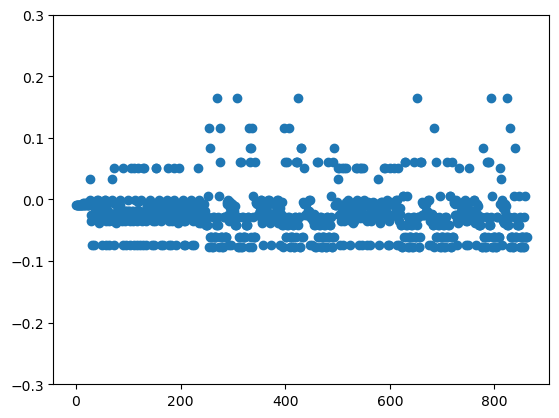

In [6]:
diff = df[~df["isOpt"]]["E"] - df_dual.loc[df[~df["isOpt"]].index]["E"]
plt.scatter((range(len(diff))),y = diff.values)
plt.ylim(-0.3,0.3)

In [3]:
df_1 = pd.read_csv("df_CSP_p1_External=1.csv",index_col=0,dtype={'solutions':str})
df_2 = pd.read_csv("df_CSP_p1_External=2.csv",index_col=0,dtype={'solutions':str})

In [4]:
df_1.shape

(13122, 12)

In [5]:
p1E1_Numfail= df_1[~df_1["isOpt"]].shape[0] # p=1 E=1 
print("p=1 External=1 fail Number: ", p1E1_Numfail)
print("fail ratio: {:.4f}".format(p1E1_Numfail/df_1.shape[0]))

p=1 External=1 fail Number:  231
fail ratio: 0.0176


In [6]:
df_1[~df_1["isOpt"]]["formula"]

21        (0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0)
23        (0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0)
61        (0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)
62       (0, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0)
63        (0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)
                              ...                       
12950    (1, 1, 1, -1, 1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0)
13052    (1, 1, 1, 1, -1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0)
13054    (1, 1, 1, 1, -1, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0)
13092    (1, 1, 1, 1, 1, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0)
13094    (1, 1, 1, 1, 1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0)
Name: formula, Length: 231, dtype: object

In [7]:
p1E2_Numfail= df_2[~df_2["isOpt"]].shape[0] # p=1 E=2
print("p=1 External=2 fail Number: ", p1E2_Numfail)
print("fail ratio: {:.4f}".format(p1E2_Numfail/df_2.shape[0]))

p=1 External=2 fail Number:  6931
fail ratio: 0.0660


In [8]:
import numpy as np                                          # 导入numpy库并简写为np
import pandas as pd
import itertools
from joblib import Parallel, delayed
import argparse
from tqdm import tqdm
from QAOA_CSP import CSP, _H,getBaseProb
import time

In [9]:
def create_new_dict(nested_dict, func) -> dict:
    new_dict = {}
    for key, value in nested_dict.items():
        if isinstance(value, dict):
            new_dict[key] = create_new_dict(value, func)
        else:
            new_key, new_value = func(key, value)
            new_dict[new_key] = new_value
    
    return new_dict

# 将二层的key转化为我要的形式的字符串
def modify_key_value(key, value):
    operLst = ",".join(list(map(lambda x:str(eval(x[2]) - 1),key.split())))

    return operLst, value
def Qaoa3E(Problem:dict,HC,gammaLst:list,betaLst:list,p:int,s:np.ndarray) -> float:
    model = CSP(Problem,HC)
    model.updateQC(gammaLst,betaLst,p)
    return model.getExpctation(s)

# Problem转为经典表达式
def paraCSP(Problem,z1,z2,z3,z4):
    C = 0
    Problem_beta = Problem[1]
    Constant = Problem[2]
    factor = Problem[3]
    for _, Power in Problem_beta.items(): #每个次幂的
        for key, coef in Power.items(): #某个次幂中 每个项
            # 解析每个项的表达式，并乘value系数
            item = 1
            for oper in key.split(): 
                item  = item * eval("z{}".format(oper[2]))
            C  = C + item*coef 
    return factor*(C+Constant)
def GridSearch_CSP(Problem):
    sulotionsSet = itertools.product([-1,1],repeat=4)
    obj_maxLst = [0]
    para_max = []
    for z1,z2,z3,z4 in sulotionsSet:
        obj = paraCSP(Problem,z1,z2,z3,z4)
        if obj > obj_maxLst[0]:
            obj_maxLst = [obj]
            para_max = [(z1,z2,z3,z4)]
        elif obj == obj_maxLst[0]:
            obj_maxLst.append(obj)
            para_max.append((z1,z2,z3,z4))
        else:
            pass
    return obj_maxLst,para_max
# 结果评价指标 信息熵

def Entropy(probabilities:np.ndarray):
    # 计算数组中每个元素的概率
    # 计算信息熵
    entropy = -np.sum(probabilities * np.log(probabilities))
    # 归一化信息熵
    n_entropy = 1 - (entropy / np.log(probabilities.size))
    
    return n_entropy

def process_p2(row,i,p): #并行计算p=2时每种问题的情况
    start = time.time()
    CtrlSeries = row["formula"]
    Power_1 = {"Z_1":CtrlSeries[0], "Z_2":CtrlSeries[1], "Z_3":CtrlSeries[2],"Z_4":CtrlSeries[3]}
    Power_2 = {"Z_1 Z_2":CtrlSeries[4], "Z_3 Z_4":CtrlSeries[5],
            "Z_1 Z_3":CtrlSeries[6], "Z_1 Z_4":CtrlSeries[7], "Z_2 Z_3":CtrlSeries[8], "Z_2 Z_4":CtrlSeries[9]}
    Power_3 = {"Z_1 Z_2 Z_3":CtrlSeries[10], "Z_1 Z_2 Z_4":CtrlSeries[11], "Z_1 Z_3 Z_4": CtrlSeries[12] , "Z_2 Z_3 Z_4":CtrlSeries[13]}
    Power_4 = {"Z_1 Z_2 Z_3 Z_4":CtrlSeries[14]}
    Problem_beta = {"Power_1":Power_1,
            "Power_2":Power_2,
            "Power_3":Power_3,
            "Power_4":Power_4}
    Problem_alpha = create_new_dict(Problem_beta , modify_key_value)
    Problem = (Problem_alpha,Problem_beta, Constant, factor)
    #----------------- 获取CSP(Problem)
    model = CSP(Problem)
    HC = model.HC
    global loopSeries
    #loopSeries = list(itertools.product(gamma_1Lst,gamma_1Lst,beta_1Lst,beta_1Lst))
    E_lst = Parallel(n_jobs=12,verbose=0)(delayed(Qaoa3E)(Problem,HC,[gamma_1,gamma_2],[beta_1,beta_2],p,s) 
                    for gamma_1,gamma_2,beta_1,beta_2 in loopSeries)
    df = pd.DataFrame(loopSeries, columns=["gamma_1","gamma_2","beta_1","beta_2"]) #得到参数的数据框
    df.insert(0,column="E",value = E_lst) #将E_lst插入数据框
    row = df.loc[df["E"].idxmax(),:] # E_max对应列
    model.updateQC([row["gamma_1"],row["gamma_2"]],[row["beta_1"],row["beta_2"]],p)
    pureState = model.getState(s) # 返回该最优量子线路输出的纯态
    State = getBaseProb(pureState).real #得到概率向量
    idxMax = np.argmax(State) #binary变量为 二进制编码的解
    binary = bin(idxMax)[2:].zfill(4)
    #--------------- 上述为量子部分，下述为经典网格搜索部分
    ObjLst,Num_solution_Lst = GridSearch_CSP(Problem)
    New_Num_solution_Lst = []
    for lt in Num_solution_Lst:
        New_Num_solution_Lst.append(''.join(str(int((1-x)/2)) for x in lt))
    #------------输出期望，QAOA的最优解，概率向量的信息熵，gamma_1,gamma_2, beta_1,beta_2, 经典最优目标值向量(可能由多解)，经典最优解向量，QAOA的解是否为最优解之一
    end = time.time()
    print(i, " Time cost is minutes", np.round((end-start)/60,4))
    return row["E"],binary,Entropy(State),row["gamma_1"],row["gamma_2"],row["beta_1"],row["beta_2"],ObjLst,New_Num_solution_Lst,binary in New_Num_solution_Lst


In [105]:
df_2 = pd.read_csv("df_CSP_p1_External=2.csv",index_col=0,dtype={'solutions':str})
df_2[~df_2["isOpt"]]

,E,ratio,solutions,real_solutions,isOpt,Entropy,gamma_1,gamma_2,beta_1,beta_2,formula,MaxObj
42,0.998533,0.499267,0010,"['1100', '1001', '0100', '0001']",False,0.247827,4.766554,NaN,1.570796,NaN,"(0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0)","[2, 2, 2, 2]"
43,0.998533,0.499267,0000,"['1110', '1011', '0110', '0011']",False,0.247827,4.766554,NaN,1.570796,NaN,"(0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0)","[2, 2, 2, 2]"
47,0.998533,0.499267,0101,"['1110', '1100', '1011', '1001']",False,0.247827,4.766554,NaN,1.570796,NaN,"(0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0)","[2, 2, 2, 2]"
56,0.998533,0.499267,0001,"['1111', '1101', '1010', '1000']",False,0.247827,4.766554,NaN,1.570796,NaN,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0)","[2, 2, 2, 2]"
62,0.998533,0.499267,0001,"['1100', '1010', '0100', '0010']",False,0.247827,4.766554,NaN,1.570796,NaN,"(0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0)","[2, 2, 2, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...
104766,2.332604,0.388767,0000,['0001'],False,0.204903,0.649985,NaN,0.897598,NaN,"(1, 1, 1, 1, 1, -1, 0, 0, 1, 0, 0, -1, 0, 0, 0)",[6]
104786,2.299042,0.383174,0000,['0010'],False,0.158034,0.649985,NaN,0.673198,NaN,"(1, 1, 1, 1, 1, -1, 0, 1, 0, 0, 0, 0, 0, 0, -1)",[6]
104794,2.332604,0.388767,0000,['0010'],False,0.204903,0.649985,NaN,0.897598,NaN,"(1, 1, 1, 1, 1, -1, 0, 1, 0, 0, -1, 0, 0, 0, 0)",[6]
104816,2.299042,0.383174,0000,['0001'],False,0.158034,0.649985,NaN,0.673198,NaN,"(1, 1, 1, 1, 1, -1, 1, 0, 0, 0, 0, 0, 0, 0, -1)",[6]


In [192]:
df_2 = pd.read_csv("df_CSP_p1_External=2.csv",index_col=0,dtype={'solutions':str})
df_CSP = df_2[~df_2["isOpt"]].copy()



In [193]:
df_rest = df_CSP.copy()
df_rest["E"] = np.nan
df_rest["ratio"] = np.nan
df_rest["solutions"] = np.nan
df_rest["isOpt"] = np.nan
df_rest["Entropy"] = np.nan
df_rest["formula"] = df_CSP["formula"].apply(eval)


In [195]:
N = 20
Constant = 0
factor = 1
num_cores = 1
p = 2
t = np.concatenate((np.array([1]) , np.zeros((15)))).reshape(-1,1) #创建初态
s = (_H() + _H() + _H() + _H()).dot(t).to_array()
gamma_1Lst = np.linspace(0,2*np.pi,N*2) #生成遍历参数列表
beta_1Lst = np.linspace(0,np.pi,N) 
loopSeries = list(itertools.product(gamma_1Lst,gamma_1Lst,beta_1Lst,beta_1Lst))
fill_data = Parallel(n_jobs=1,timeout = None)(delayed(process_p2)(row,i,p) 
                    for i,row in tqdm(list(df_rest.iterrows())))
fill_df = pd.DataFrame(data = fill_data,index = df_rest.index,columns = ["E", "solutions", "Entropy","gamma_1","gamma_2", "beta_1", "beta_2", "MaxObj","real_solutions","isOpt"])
for col in fill_df: #将输出填入df_CSP数据框中
    df_rest[col] = fill_df[col]

tmpLst =  df_rest.apply(lambda row: row["E"]/ row["MaxObj"][0],axis = 1)
df_rest["ratio"] = tmpLst

42  Time cost is minutes 1.6269


100%|██████████| 2/2 [03:15<00:00, 97.65s/it]

43  Time cost is minutes 1.6277
